# FilmFusion Initial Exploratory Data Analysis

This notebook provides comprehensive exploratory data analysis of the MovieLens dataset after ETL processing.

## Table of Contents
1. [Data Loading](#data-loading)
2. [Basic Statistics](#basic-statistics)
3. [Rating Analysis](#rating-analysis)
4. [Movie Analysis](#movie-analysis)
5. [Genre Analysis](#genre-analysis)
6. [User Behavior Analysis](#user-behavior)
7. [Data Quality Assessment](#data-quality)
8. [Insights and Recommendations](#insights)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from pathlib import Path
import sys
import os
import warnings
warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath('..'))


In [2]:
from src.database.db_connector import DatabaseConnector
from sqlalchemy import text

In [3]:
# Configure visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
# Configure plotly
import plotly.io as pio
pio.templates.default = "plotly_white"

## Data Loading

Loading processed data from the ETL pipeline and associated metadata files.


In [6]:
# Load processed data
processed_dir = Path('../data/processed')

# Load from CSV files (faster for analysis)
try:
    ratings_df = pd.read_csv(processed_dir / 'ratings_cleaned.csv')
    movies_df = pd.read_csv(processed_dir / 'movies_cleaned.csv')
    
    # Convert timestamp back to datetime
    if 'timestamp' in ratings_df.columns:
        ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'])
    
    print(f" Loaded data:")
    print(f"   Ratings: {len(ratings_df):,} records")
    print(f"   Movies: {len(movies_df):,} records")
    
except FileNotFoundError:
    print(" Processed data files not found. Please run the ETL pipeline first.")
    print("Run: python scripts/run_initial_setup.py")


 Loaded data:
   Ratings: 100,836 records
   Movies: 9,742 records


In [8]:
# Load pipeline statistics and data quality report
try:
    with open(processed_dir / 'pipeline_stats.json', 'r') as f:
        pipeline_stats = json.load(f)
    
    with open(processed_dir / 'data_quality_report.json', 'r') as f:
        quality_report = json.load(f)
    
    with open(processed_dir / 'genre_statistics.json', 'r') as f:
        genre_stats = json.load(f)
    
    print(" Loaded pipeline metadata successfully!")
    
except FileNotFoundError as e:
    print(f"  Some metadata files not found: {e}")


 Loaded pipeline metadata successfully!


In [9]:
# Display basic data structure
print(" DATA STRUCTURE")
print("=" * 50)

print("\n RATINGS DATA:")
print(f"Shape: {ratings_df.shape}")
print(f"Columns: {list(ratings_df.columns)}")
print("\nFirst 5 rows:")
display(ratings_df.head())

print("\n MOVIES DATA:")
print(f"Shape: {movies_df.shape}")
print(f"Columns: {list(movies_df.columns)}")
print("\nFirst 5 rows:")
display(movies_df.head())


 DATA STRUCTURE

 RATINGS DATA:
Shape: (100836, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']

First 5 rows:


,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51



 MOVIES DATA:
Shape: (9742, 8)
Columns: ['movieId', 'title', 'genres', 'year', 'clean_title', 'genre_count', 'genres_list', 'genres_normalized']

First 5 rows:


,movieId,title,genres,year,clean_title,genre_count,genres_list,genres_normalized
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0,Toy Story,5,"['Adventure', 'Animation', ""Children's"", 'Come...",Adventure|Animation|Children's|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0,Jumanji,3,"['Adventure', ""Children's"", 'Fantasy']",Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0,Grumpier Old Men,2,"['Comedy', 'Romance']",Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0,Waiting to Exhale,3,"['Comedy', 'Drama', 'Romance']",Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy,1995.0,Father of the Bride Part II,1,['Comedy'],Comedy


## Basic Statistics

Overview of dataset characteristics and fundamental statistics.


In [11]:
# Display basic dataset information
print(" DATASET OVERVIEW")
print("=" * 50)

# Basic counts
unique_users = ratings_df['userId'].nunique()
unique_movies = ratings_df['movieId'].nunique()
total_ratings = len(ratings_df)

print(f"Total Ratings: {total_ratings:,}")
print(f"Unique Users: {unique_users:,}")
print(f"Unique Movies: {unique_movies:,}")
print(f"Movies in Catalog: {len(movies_df):,}")

 DATASET OVERVIEW
Total Ratings: 100,836
Unique Users: 610
Unique Movies: 9,724
Movies in Catalog: 9,742


In [12]:
# Calculate sparsity
sparsity = 1 - (total_ratings / (unique_users * unique_movies))
print(f"\nMatrix Sparsity: {sparsity:.4f} ({sparsity*100:.2f}% empty)")


Matrix Sparsity: 0.9830 (98.30% empty)


In [15]:
# Rating statistics
print(f"\n RATING STATISTICS")
print(f"Average Rating: {ratings_df['rating'].mean():.2f}")
print(f"Rating Range: {ratings_df['rating'].min()} - {ratings_df['rating'].max()}")
print(f"Rating Std Dev: {ratings_df['rating'].std():.2f}")


 RATING STATISTICS
Average Rating: 3.50
Rating Range: 0.5 - 5.0
Rating Std Dev: 1.04


In [16]:
# Time period

if 'timestamp' in ratings_df.columns:
    print(f"\n TIME PERIOD")
    print(f"Earliest Rating: {ratings_df['timestamp'].min()}")
    print(f"Latest Rating: {ratings_df['timestamp'].max()}")
    time_span = ratings_df['timestamp'].max() - ratings_df['timestamp'].min()
    print(f"Time Span: {time_span.days} days")


 TIME PERIOD
Earliest Rating: 1996-03-29 18:36:55
Latest Rating: 2018-09-24 14:27:30
Time Span: 8213 days


## Rating Analysis

Comprehensive analysis of rating patterns, distributions, and user/movie activity.


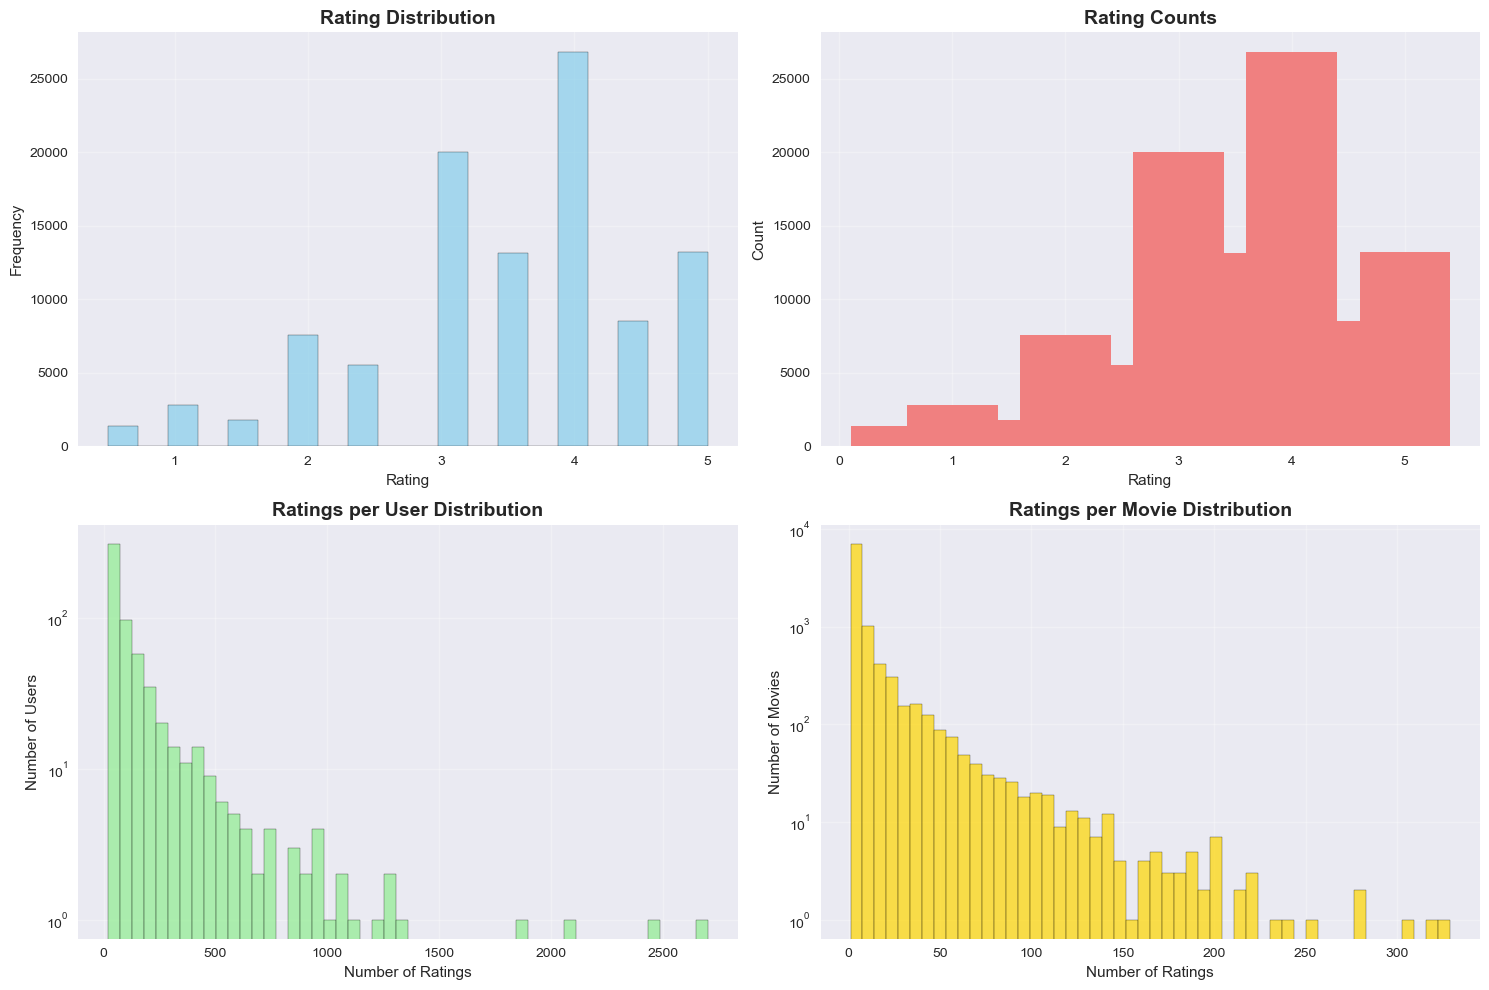

In [17]:
# Rating distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating histogram
axes[0, 0].hist(ratings_df['rating'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Rating counts
rating_counts = ratings_df['rating'].value_counts().sort_index()
axes[0, 1].bar(rating_counts.index, rating_counts.values, color='lightcoral')
axes[0, 1].set_title('Rating Counts', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].grid(True, alpha=0.3)

# Ratings per user
ratings_per_user = ratings_df.groupby('userId').size()
axes[1, 0].hist(ratings_per_user, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Ratings per User Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Ratings')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Ratings per movie
ratings_per_movie = ratings_df.groupby('movieId').size()
axes[1, 1].hist(ratings_per_movie, bins=50, edgecolor='black', alpha=0.7, color='gold')
axes[1, 1].set_title('Ratings per Movie Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Ratings')
axes[1, 1].set_ylabel('Number of Movies')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [18]:
# Print detailed statistics
print(" RATING ACTIVITY SUMMARY")
print("=" * 40)

print(f"Users who rated only 1 movie: {(ratings_per_user == 1).sum():,} ({(ratings_per_user == 1).mean()*100:.1f}%)")
print(f"Movies with only 1 rating: {(ratings_per_movie == 1).sum():,} ({(ratings_per_movie == 1).mean()*100:.1f}%)")
print(f"Most active user rated {ratings_per_user.max()} movies")
print(f"Most rated movie has {ratings_per_movie.max()} ratings")

# Additional statistics
print(f"\n DISTRIBUTION DETAILS:")
print(f"Median ratings per user: {ratings_per_user.median():.0f}")
print(f"Median ratings per movie: {ratings_per_movie.median():.0f}")
print(f"Users with 10+ ratings: {(ratings_per_user >= 10).sum():,} ({(ratings_per_user >= 10).mean()*100:.1f}%)")
print(f"Movies with 10+ ratings: {(ratings_per_movie >= 10).sum():,} ({(ratings_per_movie >= 10).mean()*100:.1f}%)")


 RATING ACTIVITY SUMMARY
Users who rated only 1 movie: 0 (0.0%)
Movies with only 1 rating: 3,446 (35.4%)
Most active user rated 2698 movies
Most rated movie has 329 ratings

 DISTRIBUTION DETAILS:
Median ratings per user: 70
Median ratings per movie: 3
Users with 10+ ratings: 610 (100.0%)
Movies with 10+ ratings: 2,269 (23.3%)


## Movie Analysis

Analysis of movie characteristics, release patterns, and popularity metrics.


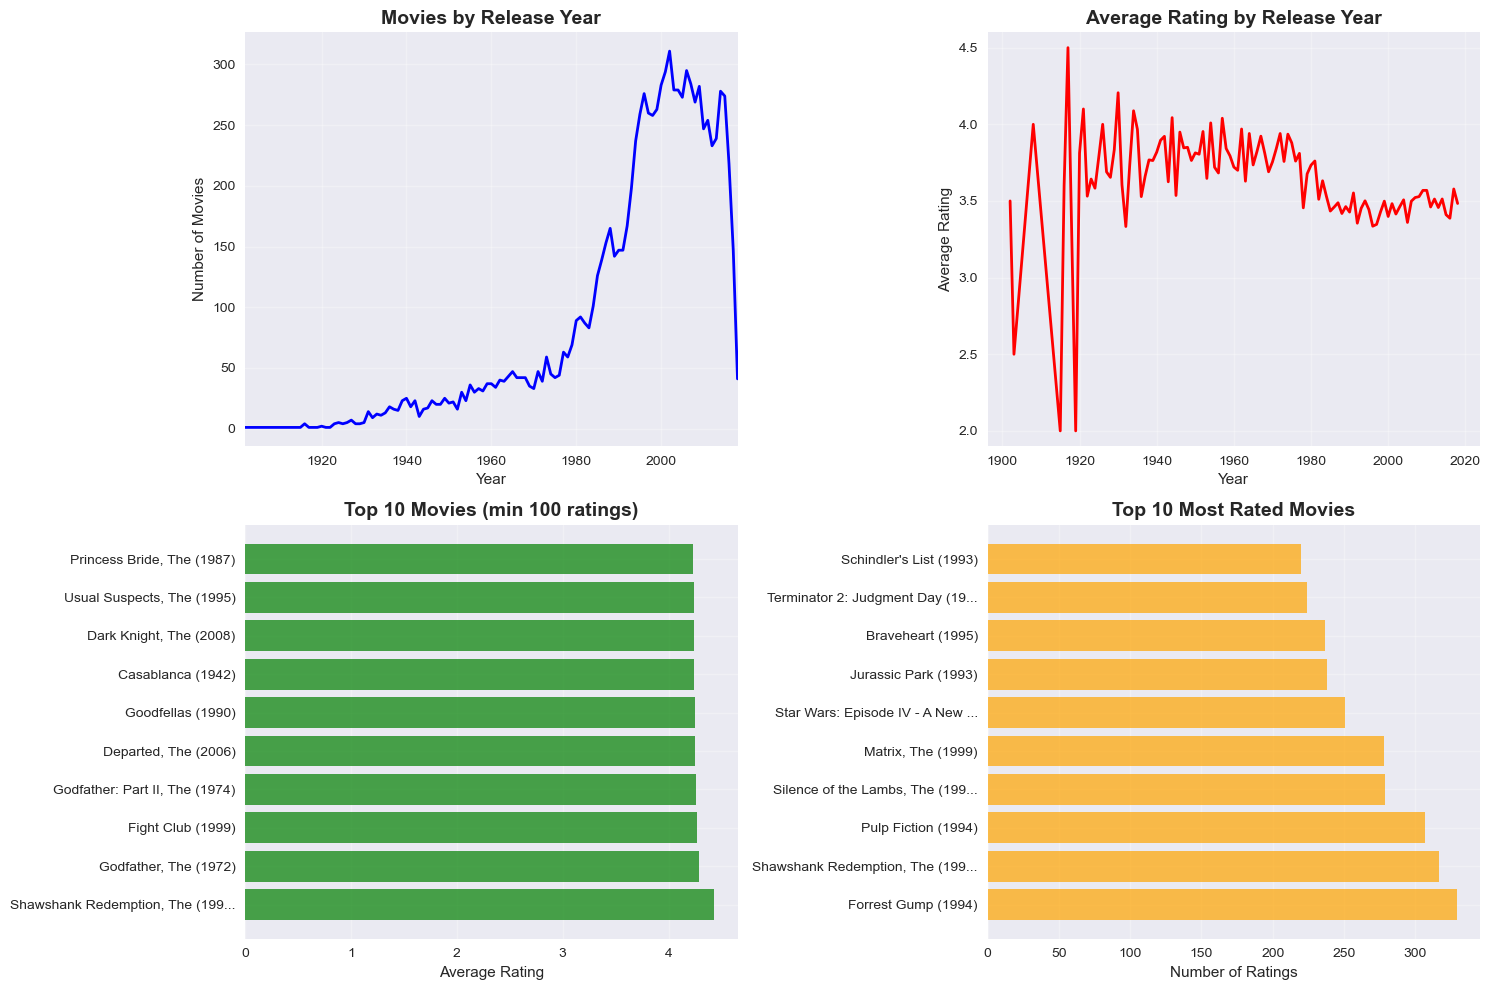

In [19]:
# Movie analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Movies by year
if 'year' in movies_df.columns:
    year_counts = movies_df.dropna(subset=['year'])['year'].value_counts().sort_index()
    axes[0, 0].plot(year_counts.index, year_counts.values, linewidth=2, color='blue')
    axes[0, 0].set_title('Movies by Release Year', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of Movies')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim(year_counts.index.min(), year_counts.index.max())

# Average rating by year
if 'year' in movies_df.columns:
    # Merge ratings with movies to get years
    ratings_with_year = ratings_df.merge(movies_df[['movieId', 'year']], on='movieId')
    avg_rating_by_year = ratings_with_year.groupby('year')['rating'].mean()
    
    axes[0, 1].plot(avg_rating_by_year.index, avg_rating_by_year.values, linewidth=2, color='red')
    axes[0, 1].set_title('Average Rating by Release Year', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Average Rating')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim(avg_rating_by_year.min() - 0.1, avg_rating_by_year.max() + 0.1)

# Top rated movies (with minimum ratings threshold)
min_ratings = 100
movie_stats = ratings_df.groupby('movieId').agg({
    'rating': ['mean', 'count']
}).round(2)
movie_stats.columns = ['avg_rating', 'num_ratings']
movie_stats = movie_stats[movie_stats['num_ratings'] >= min_ratings]

# Merge with movie titles
top_movies = movie_stats.merge(movies_df[['movieId', 'title']], on='movieId')
top_movies = top_movies.sort_values('avg_rating', ascending=False).head(10)

axes[1, 0].barh(range(len(top_movies)), top_movies['avg_rating'], color='green', alpha=0.7)
axes[1, 0].set_yticks(range(len(top_movies)))
axes[1, 0].set_yticklabels([title[:30] + '...' if len(title) > 30 else title 
                           for title in top_movies['title']], fontsize=10)
axes[1, 0].set_title(f'Top 10 Movies (min {min_ratings} ratings)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].grid(True, alpha=0.3)

# Most rated movies
most_rated = movie_stats.merge(movies_df[['movieId', 'title']], on='movieId')
most_rated = most_rated.sort_values('num_ratings', ascending=False).head(10)

axes[1, 1].barh(range(len(most_rated)), most_rated['num_ratings'], color='orange', alpha=0.7)
axes[1, 1].set_yticks(range(len(most_rated)))
axes[1, 1].set_yticklabels([title[:30] + '...' if len(title) > 30 else title 
                           for title in most_rated['title']], fontsize=10)
axes[1, 1].set_title('Top 10 Most Rated Movies', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Ratings')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
# Movie statistics summary
print(" MOVIE ANALYSIS SUMMARY")
print("=" * 40)

if 'year' in movies_df.columns:
    year_stats = movies_df['year'].describe()
    print(f"Movie year range: {int(year_stats['min'])} - {int(year_stats['max'])}")
    print(f"Most productive decade: {year_counts.groupby(year_counts.index // 10 * 10).sum().idxmax()}s")
    print(f"Peak movie year: {year_counts.idxmax()} ({year_counts.max()} movies)")

print(f"\nTop rated movie (min {min_ratings} ratings): {top_movies.iloc[0]['title']} ({top_movies.iloc[0]['avg_rating']:.2f})")
print(f"Most rated movie: {most_rated.iloc[0]['title']} ({most_rated.iloc[0]['num_ratings']:,} ratings)")

# Calculate additional movie metrics
print(f"\n MOVIE METRICS:")
print(f"Movies with 50+ ratings: {(movie_stats['num_ratings'] >= 50).sum():,}")
print(f"Movies with 4.0+ average rating: {(movie_stats['avg_rating'] >= 4.0).sum():,}")
print(f"Blockbuster movies (500+ ratings): {(movie_stats['num_ratings'] >= 500).sum():,}")


 MOVIE ANALYSIS SUMMARY
Movie year range: 1902 - 2018
Most productive decade: 2000.0s
Peak movie year: 2002.0 (311 movies)

Top rated movie (min 100 ratings): Shawshank Redemption, The (1994) (4.43)
Most rated movie: Forrest Gump (1994) (329 ratings)

 MOVIE METRICS:
Movies with 50+ ratings: 138
Movies with 4.0+ average rating: 49
Blockbuster movies (500+ ratings): 0


## Genre Analysis

Comprehensive analysis of movie genres, their popularity, and rating patterns.


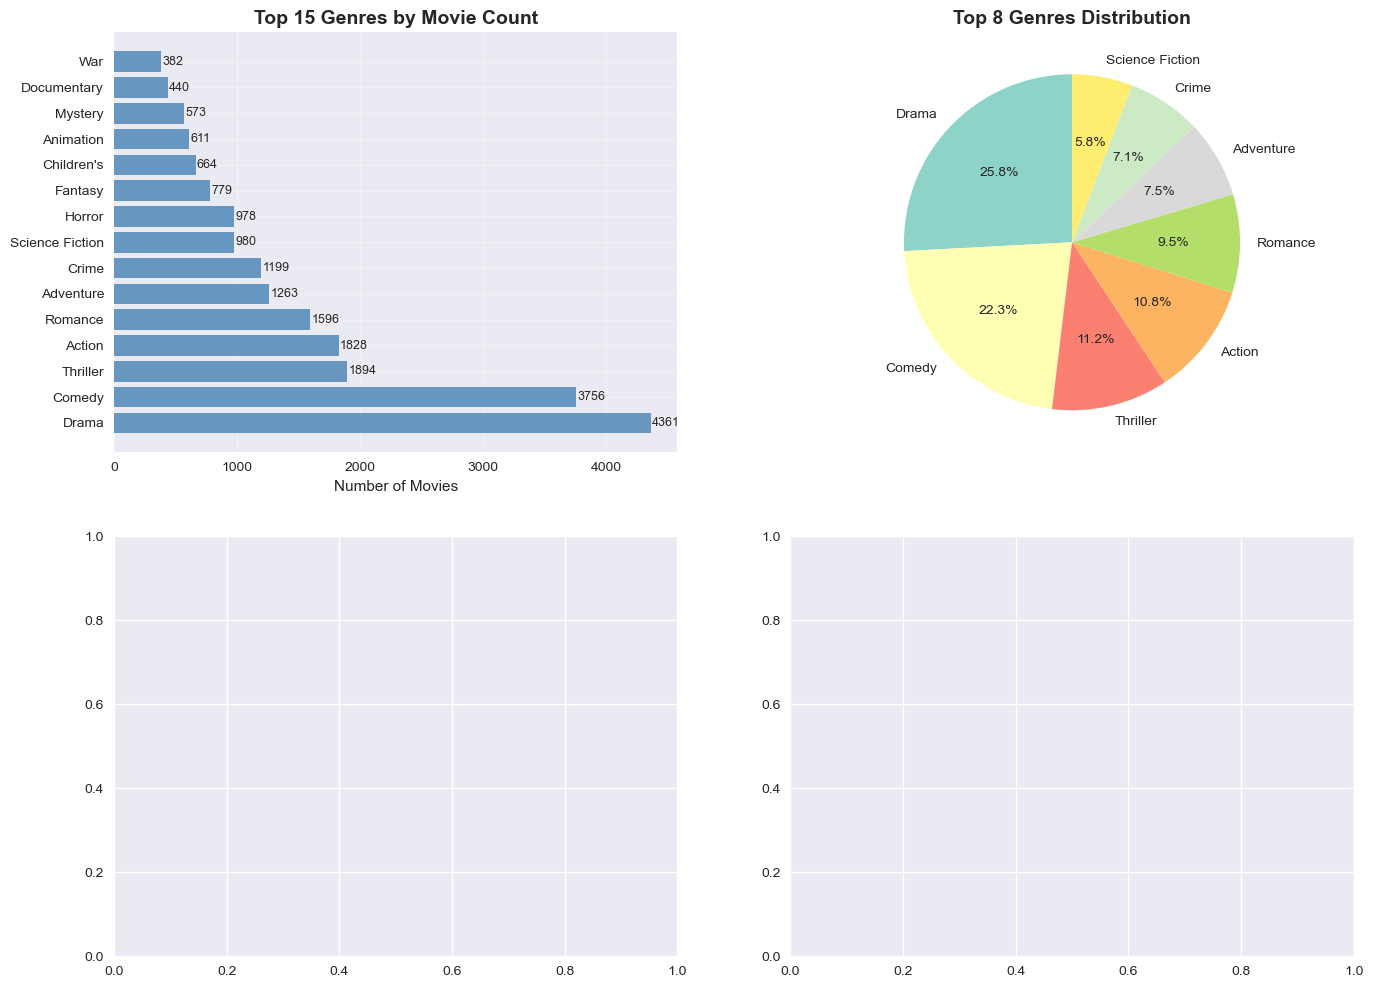

In [22]:
# Genre analysis
if 'genres_list' in movies_df.columns:
    # Extract all genres
    all_genres = []
    for genres_list in movies_df['genres_list']:
        if isinstance(genres_list, str):
            try:
                # Handle string representation of list
                genres_list = eval(genres_list)
            except:
                # Handle pipe-separated string
                genres_list = genres_list.split('|')
        if isinstance(genres_list, list):
            all_genres.extend([g.strip() for g in genres_list if g.strip()])
    
    genre_counts = pd.Series(all_genres).value_counts()
    
    # Genre popularity visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top genres by movie count
    top_genres = genre_counts.head(15)
    bars = axes[0, 0].barh(range(len(top_genres)), top_genres.values, color='steelblue', alpha=0.8)
    axes[0, 0].set_yticks(range(len(top_genres)))
    axes[0, 0].set_yticklabels(top_genres.index)
    axes[0, 0].set_title('Top 15 Genres by Movie Count', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Number of Movies')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0, 0].text(width + 10, bar.get_y() + bar.get_height()/2, 
                       f'{int(width)}', ha='left', va='center', fontsize=9)
    
    # Genre pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, 8))
    wedges, texts, autotexts = axes[0, 1].pie(top_genres.head(8).values, 
                                             labels=top_genres.head(8).index, 
                                             autopct='%1.1f%%',
                                             colors=colors,
                                             startangle=90)
    axes[0, 1].set_title('Top 8 Genres Distribution', fontsize=14, fontweight='bold')
    
else:
    print("  Genre information not available in the expected format.")
    

In [ ]:
#  genre analysis - ratings by genre
if 'all_genres' in locals() and len(all_genres) > 0:
    # Average rating by genre
    genre_ratings = []
    
    for genre in genre_counts.head(10).index:
        # Find movies with this genre
        if 'genres_list' in movies_df.columns:
            genre_movies = movies_df[movies_df['genres_list'].astype(str).str.contains(genre, na=False)]['movieId']
        else:
            genre_movies = movies_df[movies_df['genres'].astype(str).str.contains(genre, na=False)]['movieId']
        
        genre_movie_ratings = ratings_df[ratings_df['movieId'].isin(genre_movies)]['rating']
        
        if len(genre_movie_ratings) > 0:
            genre_ratings.append({
                'genre': genre,
                'avg_rating': genre_movie_ratings.mean(),
                'num_ratings': len(genre_movie_ratings),
                'num_movies': len(genre_movies)
            })
    
    genre_ratings_df = pd.DataFrame(genre_ratings)
    genre_ratings_df = genre_ratings_df.sort_values('avg_rating', ascending=False)
    
    # Plot genre ratings
    if len(axes) > 2:  # If we have the subplot array from previous cell
        colors = plt.cm.viridis(np.linspace(0, 1, len(genre_ratings_df)))
        bars1 = axes[1, 0].bar(range(len(genre_ratings_df)), genre_ratings_df['avg_rating'], color=colors)
        axes[1, 0].set_xticks(range(len(genre_ratings_df)))
        axes[1, 0].set_xticklabels(genre_ratings_df['genre'], rotation=45, ha='right')
        axes[1, 0].set_title('Average Rating by Genre', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('Average Rating')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                           f'{height:.2f}', ha='center', va='bottom', fontsize=9)
        
        # Number of ratings by genre
        bars2 = axes[1, 1].bar(range(len(genre_ratings_df)), genre_ratings_df['num_ratings'], 
                              color=colors, alpha=0.7)
        axes[1, 1].set_xticks(range(len(genre_ratings_df)))
        axes[1, 1].set_xticklabels(genre_ratings_df['genre'], rotation=45, ha='right')
        axes[1, 1].set_title('Number of Ratings by Genre', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Number of Ratings')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Print genre statistics
    print(f"\n GENRE STATISTICS")
    print("=" * 40)
    print(f"Total unique genres: {len(genre_counts)}")
    print(f"Most common genre: {genre_counts.index[0]} ({genre_counts.iloc[0]} movies)")
    print(f"Average genres per movie: {len(all_genres) / len(movies_df):.2f}")
    
    print(f"\n TOP RATED GENRES:")
    for i, row in genre_ratings_df.head(5).iterrows():
        print(f"  {row['genre']}: {row['avg_rating']:.2f} avg rating ({row['num_movies']} movies, {row['num_ratings']:,} ratings)")

else:
    print("  Genre analysis could not be completed due to data format issues.")



 GENRE STATISTICS
Total unique genres: 20
Most common genre: Drama (4361 movies)
Average genres per movie: 2.27

 TOP RATED GENRES:
  Crime: 3.66 avg rating (1199 movies, 16,681 ratings)
  Drama: 3.66 avg rating (4361 movies, 41,928 ratings)
  Adventure: 3.51 avg rating (1263 movies, 24,161 ratings)
  Romance: 3.51 avg rating (1596 movies, 18,124 ratings)
  Thriller: 3.49 avg rating (1894 movies, 26,452 ratings)


In [25]:
# User behavior analysis
user_stats = ratings_df.groupby('userId').agg({
    'rating': ['count', 'mean', 'std'],
    'movieId': 'nunique'
})
user_stats.columns = ['num_ratings', 'avg_rating', 'rating_std', 'unique_movies']
user_stats['rating_std'] = user_stats['rating_std'].fillna(0)

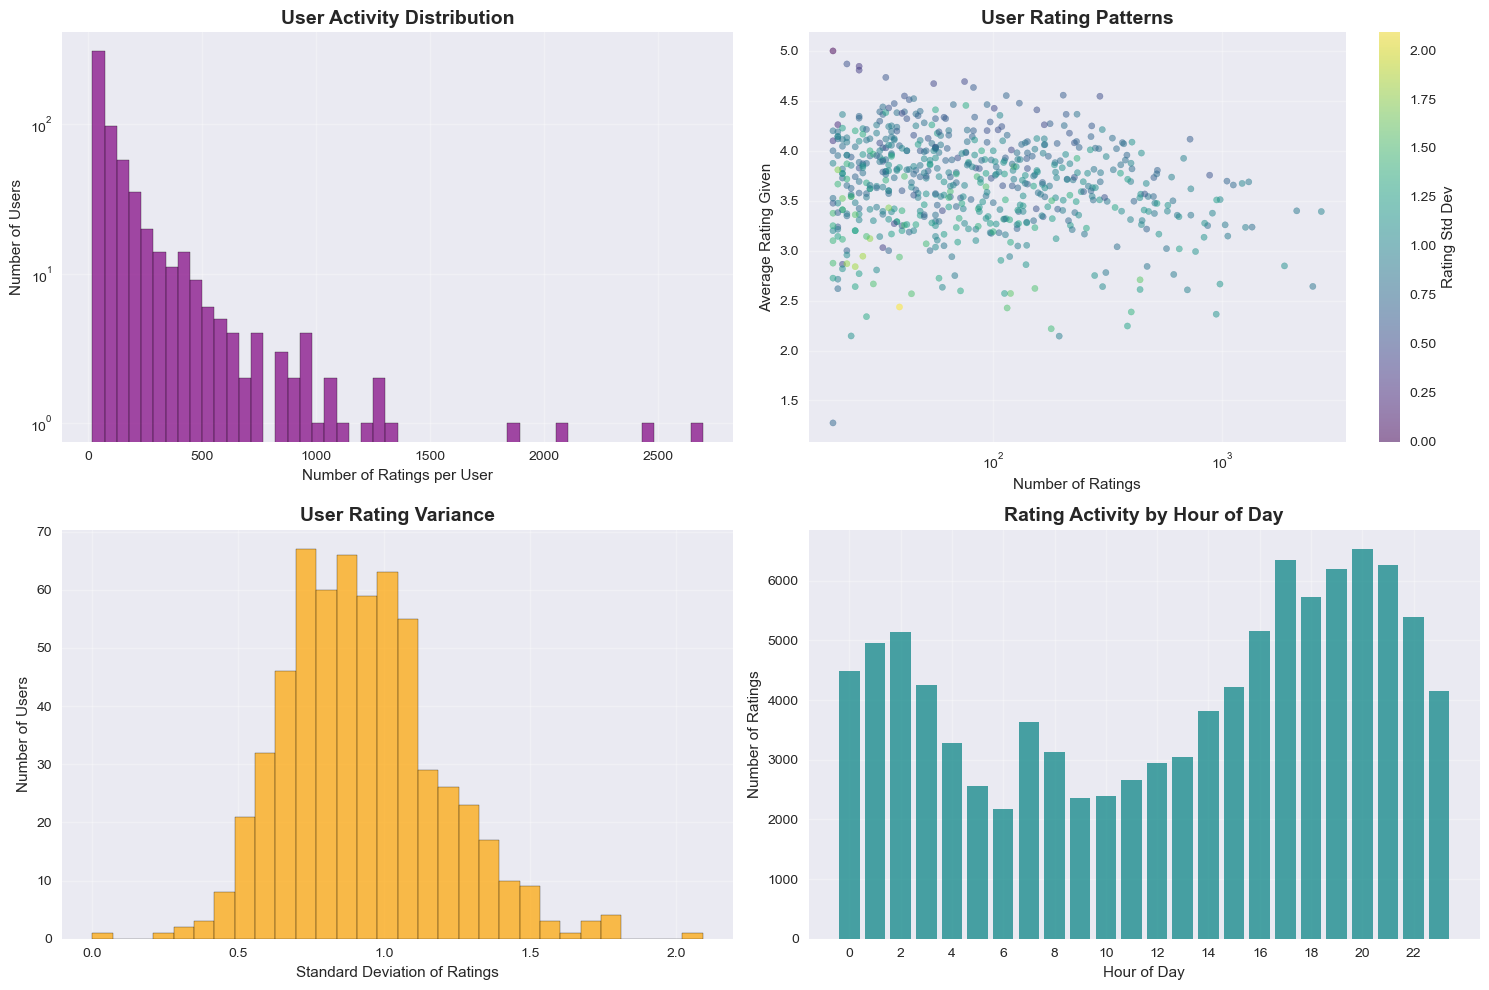

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# User activity distribution
axes[0, 0].hist(user_stats['num_ratings'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0, 0].set_title('User Activity Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Ratings per User')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True, alpha=0.3)

# User rating behavior
scatter = axes[0, 1].scatter(user_stats['num_ratings'], user_stats['avg_rating'], 
                            alpha=0.5, c=user_stats['rating_std'], cmap='viridis', s=20)
axes[0, 1].set_title('User Rating Patterns', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Ratings')
axes[0, 1].set_ylabel('Average Rating Given')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Rating Std Dev')

# Rating variance by user
axes[1, 0].hist(user_stats['rating_std'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('User Rating Variance', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Standard Deviation of Ratings')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].grid(True, alpha=0.3)

# Time-based activity (if timestamp available)
if 'timestamp' in ratings_df.columns:
    # Extract hour from timestamp
    ratings_df['hour'] = ratings_df['timestamp'].dt.hour
    hourly_activity = ratings_df['hour'].value_counts().sort_index()
    
    bars = axes[1, 1].bar(hourly_activity.index, hourly_activity.values, color='teal', alpha=0.7)
    axes[1, 1].set_title('Rating Activity by Hour of Day', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Hour of Day')
    axes[1, 1].set_ylabel('Number of Ratings')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xticks(range(0, 24, 2))
else:
    axes[1, 1].text(0.5, 0.5, 'Timestamp data not available', 
                   ha='center', va='center', transform=axes[1, 1].transAxes,
                   fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    axes[1, 1].set_title('Rating Activity by Hour of Day', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [27]:
# User segments and behavior summary
print(" USER BEHAVIOR SUMMARY")
print("=" * 40)

# User segments
light_users = (user_stats['num_ratings'] <= 10).sum()
medium_users = ((user_stats['num_ratings'] > 10) & (user_stats['num_ratings'] <= 50)).sum()
heavy_users = (user_stats['num_ratings'] > 50).sum()

print(f"Light users (1-10 ratings): {light_users:,} ({light_users/len(user_stats)*100:.1f}%)")
print(f"Medium users (11-50 ratings): {medium_users:,} ({medium_users/len(user_stats)*100:.1f}%)")
print(f"Heavy users (51+ ratings): {heavy_users:,} ({heavy_users/len(user_stats)*100:.1f}%)")

print(f"\n RATING BEHAVIOR")
print(f"Average user rating: {user_stats['avg_rating'].mean():.2f}")
print(f"Most generous user avg rating: {user_stats['avg_rating'].max():.2f}")
print(f"Most critical user avg rating: {user_stats['avg_rating'].min():.2f}")
print(f"Average rating std dev: {user_stats['rating_std'].mean():.2f}")

# Additional insights
print(f"\n ENGAGEMENT INSIGHTS:")
print(f"Users rating >100 movies: {(user_stats['num_ratings'] > 100).sum():,}")
print(f"Users with very high variance (>1.5): {(user_stats['rating_std'] > 1.5).sum():,}")
print(f"Users who rate everything highly (>4.5 avg): {(user_stats['avg_rating'] > 4.5).sum():,}")
print(f"Users who are very critical (<3.0 avg): {(user_stats['avg_rating'] < 3.0).sum():,}")

if 'timestamp' in ratings_df.columns:
    peak_hour = hourly_activity.idxmax()
    print(f"\n TEMPORAL PATTERNS:")
    print(f"Peak activity hour: {peak_hour}:00 ({hourly_activity[peak_hour]:,} ratings)")
    print(f"Lowest activity hour: {hourly_activity.idxmin()}:00 ({hourly_activity.min():,} ratings)")


 USER BEHAVIOR SUMMARY
Light users (1-10 ratings): 0 (0.0%)
Medium users (11-50 ratings): 232 (38.0%)
Heavy users (51+ ratings): 378 (62.0%)

 RATING BEHAVIOR
Average user rating: 3.66
Most generous user avg rating: 5.00
Most critical user avg rating: 1.27
Average rating std dev: 0.93

 ENGAGEMENT INSIGHTS:
Users rating >100 movies: 245
Users with very high variance (>1.5): 15
Users who rate everything highly (>4.5 avg): 14
Users who are very critical (<3.0 avg): 49

 TEMPORAL PATTERNS:
Peak activity hour: 20:00 (6,533 ratings)
Lowest activity hour: 6:00 (2,168 ratings)


## Data Quality Assessment

Comprehensive evaluation of data quality, completeness, and potential issues.


In [28]:
# Data quality assessment
print(" DATA QUALITY ASSESSMENT")
print("=" * 50)

# Display pipeline statistics if available
if 'quality_report' in locals():
    print("\n ETL PIPELINE RESULTS:")
    for dataset, stats in quality_report.get('datasets', {}).items():
        print(f"\n{dataset.upper()}:")
        print(f"  Original records: {stats.get('original_count', 'N/A'):,}")
        print(f"  Final records: {stats.get('final_count', 'N/A'):,}")
        print(f"  Data retention: {stats.get('data_quality_score', 0)*100:.1f}%")
        if 'duplicates_removed' in stats:
            print(f"  Duplicates removed: {stats['duplicates_removed']:,}")
        if 'invalid_ratings_removed' in stats:
            print(f"  Invalid ratings removed: {stats['invalid_ratings_removed']:,}")

# Current data quality checks
print(f"\n CURRENT DATA QUALITY:")

# Check for missing values
print(f"\nMissing Values:")
ratings_missing = ratings_df.isnull().sum()
movies_missing = movies_df.isnull().sum()

print(f"  Ratings dataset:")
for col, missing in ratings_missing.items():
    if missing > 0:
        print(f"    {col}: {missing:,} ({missing/len(ratings_df)*100:.2f}%)")
    
print(f"  Movies dataset:")
for col, missing in movies_missing.items():
    if missing > 0:
        print(f"    {col}: {missing:,} ({missing/len(movies_df)*100:.2f}%)")

if ratings_missing.sum() == 0:
    print("   No missing values in ratings data")
if movies_missing.sum() == 0:
    print("   No missing values in movies data")


 DATA QUALITY ASSESSMENT

 ETL PIPELINE RESULTS:

RATINGS:
  Original records: 100,836
  Final records: 100,836
  Data retention: 100.0%
  Duplicates removed: 0
  Invalid ratings removed: 0

MOVIES:
  Original records: 9,742
  Final records: 9,742
  Data retention: 100.0%

 CURRENT DATA QUALITY:

Missing Values:
  Ratings dataset:
  Movies dataset:
    year: 13 (0.13%)
   No missing values in ratings data


In [29]:
# Data integrity and consistency checks
print(f"\n DATA INTEGRITY CHECKS:")

# Check for duplicates
rating_dupes = ratings_df.duplicated(subset=['userId', 'movieId']).sum()
movie_dupes = movies_df.duplicated(subset=['movieId']).sum()
print(f"\nDuplicates:")
print(f"  Rating duplicates: {rating_dupes}")
print(f"  Movie duplicates: {movie_dupes}")

# Check data types
print(f"\nData Types:")
print(f"  Ratings dtypes: {dict(ratings_df.dtypes)}")
print(f"  Movies dtypes: {dict(movies_df.dtypes)}")

# Check value ranges
print(f"\nValue Ranges:")
print(f"  Rating range: {ratings_df['rating'].min()} - {ratings_df['rating'].max()}")
print(f"  User ID range: {ratings_df['userId'].min():,} - {ratings_df['userId'].max():,}")
print(f"  Movie ID range: {ratings_df['movieId'].min():,} - {ratings_df['movieId'].max():,}")


 DATA INTEGRITY CHECKS:

Duplicates:
  Rating duplicates: 0
  Movie duplicates: 0

Data Types:
  Ratings dtypes: {'userId': dtype('int64'), 'movieId': dtype('int64'), 'rating': dtype('float64'), 'timestamp': dtype('<M8[ns]'), 'hour': dtype('int32')}
  Movies dtypes: {'movieId': dtype('int64'), 'title': dtype('O'), 'genres': dtype('O'), 'year': dtype('float64'), 'clean_title': dtype('O'), 'genre_count': dtype('int64'), 'genres_list': dtype('O'), 'genres_normalized': dtype('O')}

Value Ranges:
  Rating range: 0.5 - 5.0
  User ID range: 1 - 610
  Movie ID range: 1 - 193,609


In [30]:
if 'year' in movies_df.columns:
    year_stats = movies_df['year'].describe()
    print(f"  Movie year range: {year_stats['min']:.0f} - {year_stats['max']:.0f}")
    
    # Check for unreasonable years
    current_year = pd.Timestamp.now().year
    future_movies = movies_df[movies_df['year'] > current_year + 2]
    old_movies = movies_df[movies_df['year'] < 1888]  # First motion picture
    
    if len(future_movies) > 0:
        print(f"    Movies with future years: {len(future_movies)}")
    if len(old_movies) > 0:
        print(f"    Movies with very old years: {len(old_movies)}")

# Coverage analysis
print(f"\n COVERAGE ANALYSIS:")
movies_with_ratings = ratings_df['movieId'].nunique()
total_movies = len(movies_df)
coverage = movies_with_ratings / total_movies

print(f"  Movies with ratings: {movies_with_ratings:,} / {total_movies:,} ({coverage*100:.1f}%)")
print(f"  Movies without ratings: {total_movies - movies_with_ratings:,}")

# Cold start analysis
users_single_rating = (ratings_df.groupby('userId').size() == 1).sum()
movies_single_rating = (ratings_df.groupby('movieId').size() == 1).sum()

print(f"\n  COLD START CHALLENGES:")
print(f"  Users with only 1 rating: {users_single_rating:,} ({users_single_rating/unique_users*100:.1f}%)")
print(f"  Movies with only 1 rating: {movies_single_rating:,} ({movies_single_rating/ratings_df['movieId'].nunique()*100:.1f}%)")

  Movie year range: 1902 - 2018

 COVERAGE ANALYSIS:
  Movies with ratings: 9,724 / 9,742 (99.8%)
  Movies without ratings: 18

  COLD START CHALLENGES:
  Users with only 1 rating: 0 (0.0%)
  Movies with only 1 rating: 3,446 (35.4%)


## Insights and Recommendations

Key findings from the exploratory data analysis and recommendations for model development.


In [31]:
# Generate comprehensive insights and recommendations
print(" KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

print("\n DATASET CHARACTERISTICS:")
print(f" Dataset contains {total_ratings:,} ratings from {unique_users:,} users on {unique_movies:,} movies")
print(f" Matrix sparsity of {sparsity*100:.2f}% indicates significant cold-start challenges")
print(f" Average rating of {ratings_df['rating'].mean():.2f} suggests positive rating bias")

print(f"\n USER BEHAVIOR INSIGHTS:")
print(f" {light_users/len(user_stats)*100:.1f}% of users are light users (≤10 ratings) - major cold-start segment")
print(f" Power users ({(user_stats['num_ratings'] > 100).sum()}) drive significant engagement")
print(f" Rating variance suggests diverse user preferences and rating styles")

if 'genre_counts' in locals():
    print(f"\n CONTENT INSIGHTS:")
    print(f" {genre_counts.index[0]} is the most common genre ({genre_counts.iloc[0]} movies)")
    print(f" Genre diversity ({len(genre_counts)} unique genres) supports content-based filtering")
    
if 'year' in movies_df.columns:
    recent_movies = movies_df[movies_df['year'] >= 2010].shape[0]
    print(f" {recent_movies:,} recent movies (2010+) may need cold-start handling")



 KEY INSIGHTS AND RECOMMENDATIONS

 DATASET CHARACTERISTICS:
 Dataset contains 100,836 ratings from 610 users on 9,724 movies
 Matrix sparsity of 98.30% indicates significant cold-start challenges
 Average rating of 3.50 suggests positive rating bias

 USER BEHAVIOR INSIGHTS:
 0.0% of users are light users (≤10 ratings) - major cold-start segment
 Power users (245) drive significant engagement
 Rating variance suggests diverse user preferences and rating styles

 CONTENT INSIGHTS:
 Drama is the most common genre (4361 movies)
 Genre diversity (20 unique genres) supports content-based filtering
 1,931 recent movies (2010+) may need cold-start handling


In [32]:
print(f"\n TECHNICAL RECOMMENDATIONS:")
print(" Implement hybrid recommendation system combining collaborative and content-based approaches")
print(" Use popularity-based recommendations for new users (cold-start)")
print(" Consider implicit feedback models for sparse data")
print(" Implement user and item embeddings for better representation learning")

print(f"\n MODEL DEVELOPMENT PRIORITIES:")
print("1. Build baseline popularity and content-based models")
print("2. Implement matrix factorization for collaborative filtering")
print("3. Develop hybrid ensemble approach")
print("4. Address cold-start with metadata-based recommendations")
print("5. Consider sequential/session-based models for heavy users")

print(f"\n  POTENTIAL CHALLENGES:")
print(" High sparsity may affect collaborative filtering performance")
print(" Large number of single-rating users/movies creates noise")
print(" Rating bias (positive skew) may affect evaluation metrics")
print(" Temporal patterns suggest need for time-aware models")


 TECHNICAL RECOMMENDATIONS:
 Implement hybrid recommendation system combining collaborative and content-based approaches
 Use popularity-based recommendations for new users (cold-start)
 Consider implicit feedback models for sparse data
 Implement user and item embeddings for better representation learning

 MODEL DEVELOPMENT PRIORITIES:
1. Build baseline popularity and content-based models
2. Implement matrix factorization for collaborative filtering
3. Develop hybrid ensemble approach
4. Address cold-start with metadata-based recommendations
5. Consider sequential/session-based models for heavy users

  POTENTIAL CHALLENGES:
 High sparsity may affect collaborative filtering performance
 Large number of single-rating users/movies creates noise
 Rating bias (positive skew) may affect evaluation metrics
 Temporal patterns suggest need for time-aware models


In [34]:
# Prepare and export data summaries for next phase
print("\n PREPARING DATA FOR MODEL DEVELOPMENT")
print("=" * 40)

# Create summary statistics for model development
analysis_summary = {
    'dataset_stats': {
        'total_ratings': int(total_ratings),
        'unique_users': int(unique_users),
        'unique_movies': int(unique_movies),
        'sparsity': float(sparsity),
        'avg_rating': float(ratings_df['rating'].mean()),
        'rating_std': float(ratings_df['rating'].std())
    },
    'user_segments': {
        'light_users': int(light_users),
        'medium_users': int(medium_users),
        'heavy_users': int(heavy_users),
        'single_rating_users': int(users_single_rating)
    },
    'movie_stats': {
        'movies_with_ratings': int(movies_with_ratings),
        'movies_without_ratings': int(total_movies - movies_with_ratings),
        'single_rating_movies': int(movies_single_rating),
        'coverage_rate': float(coverage)
    }
}

# Add genre information if available
if 'genre_counts' in locals():
    analysis_summary['genre_stats'] = {
        'total_genres': int(len(genre_counts)),
        'top_genre': str(genre_counts.index[0]),
        'avg_genres_per_movie': float(len(all_genres) / len(movies_df))
    }

# Save analysis summary
summary_path = processed_dir / 'eda_summary.json'
with open(summary_path, 'w') as f:
    json.dump(analysis_summary, f, indent=2)

print(f" Analysis summary saved to: {summary_path}")

# Create user and movie statistics for modeling
user_features = user_stats.reset_index()
user_features.to_csv(processed_dir / 'user_features.csv', index=False)

movie_features = movie_stats.reset_index()
movie_features = movie_features.merge(movies_df[['movieId', 'title', 'year']], on='movieId', how='left')
movie_features.to_csv(processed_dir / 'movie_features.csv', index=False)

print(f" User features saved to: {processed_dir / 'user_features.csv'}")
print(f" Movie features saved to: {processed_dir / 'movie_features.csv'}")

print(f"\n EDA ANALYSIS COMPLETE!")
print("Ready to proceed to Phase 2: Model Development")



 PREPARING DATA FOR MODEL DEVELOPMENT
 Analysis summary saved to: ..\data\processed\eda_summary.json
 User features saved to: ..\data\processed\user_features.csv
 Movie features saved to: ..\data\processed\movie_features.csv

 EDA ANALYSIS COMPLETE!
Ready to proceed to Phase 2: Model Development
